In [2]:
import numpy as np
import sys
import json
import os
import utils
from scipy.special import softmax as softmax
import matplotlib.pyplot as plt

In [82]:
#Some useful functtions #to be moved to utils

def create_PObs_RR(A, M, Lx, Ly, Lx0, Ly0, find_range, cost_move, reward_find, max_obs, diff_obs, cplume):
    '''Creates the objects P(o|s,m) and R(s,m,a,s',m'). Pobs_lim is when you limit the number of observations.
    
    Inputs:
        A - number of actions [4:left,up,down,right, 5:left,up,down,right,stay]
        M - number of memory states [1,2,3,...]
        Lx,Ly - grid size
        Lx0,Ly0 - center of target area
        find_range - target area is set by a circle with radius find_range and centered at (Lx0,Ly0)
        cost_move - cost for each step made by the agent
        reward_find - reward when the agent is within the range of find_range. 
        max_obs - maximum number of observations
        diff_obs - partitioning of Y, different observatiobns. 
            For example if diff_obs=2, you have P(o=0|s,m) and P(o>0|s,m). 
            If diff_obs=3, then you have P(o=0|s,m),P(o=1|s,m),P(o>1|s,m).
        cplume - concentration map
        
    Outputs:
        PObs_lim [diff_obs,Lx,Ly,M]:  P(o|s,m), for o=0, o=1,...,o=diff_obs-2, o>diff_obs-2 
        RR [(Lx,Ly,M,A,M)]: R(s,m,a,m')
        PObs [max_obs,Lx,Ly,M]: P(o|s,m), for o=0, o=1,...,o=max_obs, o>max_obs
    '''
    
    spacex = np.arange(1,Lx+1)-(Lx+1)/2.
    spacey = np.arange(Ly)-(Ly0-1)

    # CHECK IF ORDER IS MANTAINED
    xx, yy = np.meshgrid(spacex, spacey)
    
    # ------------------  
    cplume = cplume[:,:].reshape(-1)  
    PObs = np.zeros((max_obs, Lx * Ly))
    PObs[0] = 1 - np.clip(cplume, 0, 1)
    PObs[-1,:] = 1 - np.sum(PObs[:-1,:], axis=0)
    PObs_2 = np.tile(PObs, (1,M))

    PObs_lim = np.zeros((diff_obs, Lx*Ly*M))
    PObs_lim[:] = PObs_2[:diff_obs]
    PObs_lim[-1] += np.sum(PObs_2[diff_obs:], axis=0)

    if A == 4:
        RR = utils.fast_mult.rewards_four_2d(M, Lx, Ly, Lx0+1, Ly0+1, find_range, cost_move, reward_find, max_obs)
    elif A == 5:
        RR = fast_mult.rewards_five_2d(M, Lx, Ly, Lx0+1, Ly0+1, find_range, cost_move, reward_find, max_obs)

    return np.abs(PObs_lim), RR, np.abs(PObs)

def initialize_th_eta_Q(O,M,A,Lx, Ly, Lx0, Ly0, gamma, cost_move, reward_find):
    L=Lx*Ly
    th = (np.random.rand(O, M, A*M)-0.5)*0.5 
    th[1:,:,2::A] += 0.5 #if biased
    eta = np.ones(L*M)/(L*M)/(1-gamma)
    Q = utils.create_random_Q0(Lx, Ly, Lx0, Ly0, gamma, A*M, M, cost_move, reward_find)
    return th,eta,Q

#def optimize_FSC(M,Lx,Ly,threshold,PObs,RR,initial_sm):
def single_traj_obs(pi, Lx, Ly, Lx0, Ly0, find_range, gamma, PObs, rho0, A):
  '''Creates a single trajectory given a policy. 
  This function is only for the case where cost_move=1-gamma and reward_find=0.
    
    Inputs:
        pi[O,M,M*A] - policy Prob(a,m'|m,o)
        A - number of actions [4:left,up,down,right, 5:left,up,down,right,stay]
        Lx,Ly - grid size
        Lx0,Ly0 - center of target area
        find_range - target area is set by a circle with radius find_range and centered at (Lx0,Ly0)
        PObs[diff_obs,Lx,Ly,M]
        
    Outputs:
        trj [t,5] - trajectory containing [action,x_pos,y_pos,memory state,observation received] at each time step
        ret - total reward at the end of the episode
        t - number of timesteps after target is found
    '''
  fixed_time = False
  if gamma>1: 
    fixed_time = True
    Tmax = gamma
  
  O, M, a_size = pi.shape
  m = 0
  s = np.random.choice(Lx*Ly, p=rho0[:Lx*Ly])
  x , y = (s%Lx, s//Lx)
  
  done = False
  trj=np.zeros((1,5))
  r = 0
  ret = 0
  r = np.random.choice(PObs.shape[0], p=PObs[:,s])
  o = r
  #if r > O-1: o = O-1
  #print(pi.shape)
  s0 = Lx0-1 + (Ly0-2)*Lx
  t = 0 
  while (not done):
    t += 1
    a = np.random.choice(a_size, p=pi[o,m,:])
    #print('m{}, o{}, a{}, x{}, y{}'.format( m,o, a, x,y))
    #print('s, PObs[s]', s, PObs[:,s])
    m, x, y = utils.one_step(a, x, y, Lx, Ly, A)
    #print('new x, y', x, y)
    s = x + y*Lx
    r = np.random.choice(PObs.shape[0], p=PObs[:,s])
    o = r
    #if r > O-1: o = O-1
    found = False
    if (x+1-Lx0)**2 + (y+1-Ly0)**2 < find_range**2: found = True
    if found:
      ret += 1
      done = True
      #print('Found!')
    if fixed_time and t == Tmax:
      done = True
      #print('not found')
    #if np.random.rand()<1-gamma:
    #  done = True
    trj = np.append(trj, [[a,x,y,m,r]], axis=0)
  return trj, ret, t

def threshold(pobs,threshold):
    '''set to zero the values that are less than a threshold'''
    pobs[pobs<threshold]=0
    return pobs

In [23]:
#Model of Detection
#Download concentration map from previous result through time
A=4
M=3
Lx=21
Ly=21
Lx0=10
Ly0=15
#threshold=
pobs_t=np.loadtxt('GridsLx21Ly21P100_t500')  #Size: (T x Ly x Lx) 
pobs_av=np.loadtxt('GridmeanLx21Ly21P100_t500')              #Averaged through time, given a threshold
pobs_av_sym=(pobs_av + pobs_av[:,::-1])/2                    ##Averaged through time, given a threshold then symmetrise
timestamp=90
pobs_snap=pobs_t[timestamp]/np.max(pobs_t[timestamp])            #Taking a snapshot and taking pobs from pixel intensity

#Create a PObs to be used for observation P(y|m,s)
#Size: (O,M,Ly,Lx) #Note that P(y|s) does not change regardless of the memory
gamma=0.9995
find_range = 1.1
cost_move = 1-gamma
reward_find = 0.0
max_obs = 2
O = 2



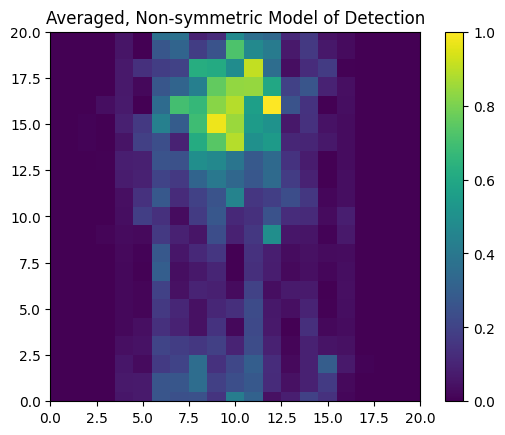

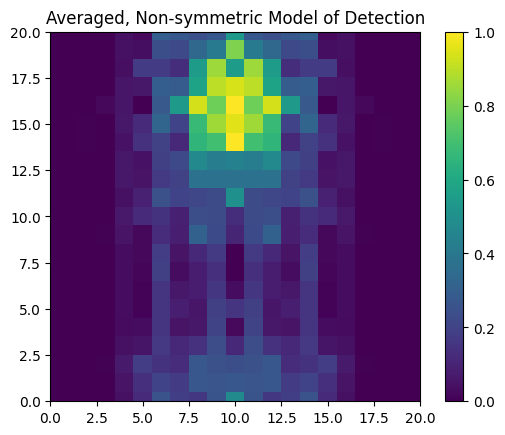

In [28]:
plt.imshow(pobs_av/np.max(pobs_av))
plt.colorbar()
plt.axis([0,20,0,20])
plt.title('Averaged, Non-symmetric Model of Detection')
plt.show()
plt.imshow(pobs_av_sym/np.max(pobs_av_sym))
#plt.scatter([Lx0],[Ly0])
plt.colorbar()
plt.axis([0,20,0,20])
plt.title('Averaged, Non-symmetric Model of Detection')
plt.show()
#pobs_th=threshold(sympobs,0.3)
#plt.imshow(pobs_th)
#plt.colorbar()
#plt.axis([0,20,0,20])
#plt.show()

(0.0, 20.0, 0.0, 20.0)

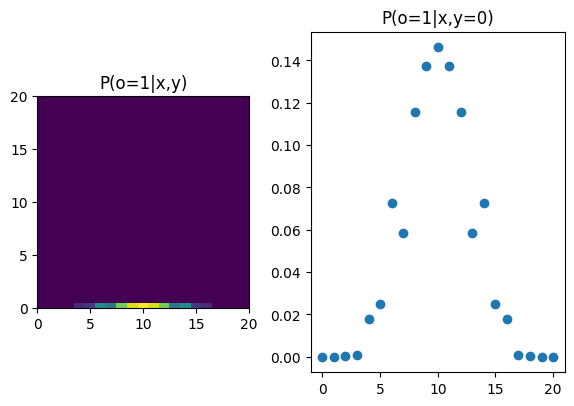

In [62]:
#Initialization 1: rho(s)~p(y=1|s) 
initial_sm=np.zeros((M,Lx,Ly))
rho=np.sum(sympobs,axis=0)
rho=rho/np.sum(rho)
initial_sm[0,0,:]=rho
fig, axs = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 1.2]},figsize=(6,4))
fig.tight_layout()
axs[1].scatter(np.arange(Lx),rho,marker='o')
axs[1].set_title('P(o=1|x,y=0)')
axs[0].imshow(initial_sm[0])
axs[0].set_title('P(o=1|x,y)')
axs[0].axis([0,20,0,20])

(0.0, 20.0, 0.0, 20.0)

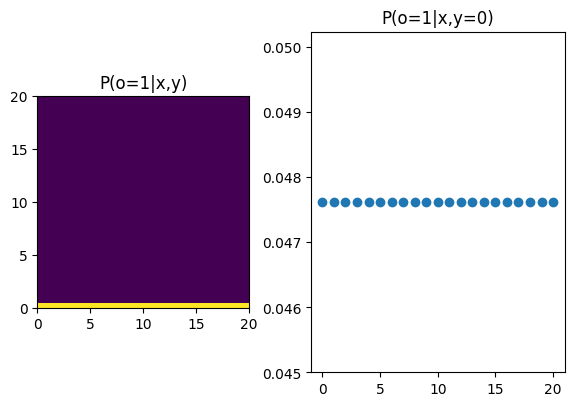

In [63]:
#Initialization 2: Uniform over Lx at Ly=0 
initial_sm2=np.zeros((M,Lx,Ly))
initial_sm2[0,0,:]=1/Lx
#Initialization 1: rho(s)~p(y=1|s) 
fig, axs = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 1.2]},figsize=(6,4))
fig.tight_layout()
axs[1].scatter(np.arange(Lx),initial_sm2[0,0,:],marker='o')
axs[1].set_title('P(o=1|x,y=0)')
axs[0].imshow(initial_sm2[0])
axs[0].set_title('P(o=1|x,y)')
axs[0].axis([0,20,0,20])

In [65]:
replica=0
lr_th=0.01
name_folder = 'A{}M{}g{}FR{}LR{}rep{}LX{}LY{}uniform'.format(A,M,gamma,find_range,lr_th,replica,Lx,Ly)
os.makedirs(name_folder, exist_ok=True)


In [66]:
#Initialize
th, eta, Q = initialize_th_eta_Q(O,M,A,Lx, Ly, Lx0, Ly0, gamma, cost_move, reward_find)
PObs,RR,__ = create_PObs_RR(A, M, Lx, Ly, Lx0, Ly0, find_range, cost_move, reward_find, max_obs, O, pobs05)


tol_eta= 0.000001
tol_Q= 0.000001
Ntot = 100000
Nprint = 100
value = 0
oldvalue = value
tol_conv=0.000000001
   
for t in range(Ntot):

    pi = softmax(th, axis=2)

    # Iterative solutions of linear system
    eta = utils.iterative_solve_eta(pi, PObs, gamma, initial_sm.reshape(-1), eta, tol_eta, Lx, Ly, Lx0, Ly0, find_range)
    Q = utils.iterative_solve_Q(pi, PObs, gamma, RR, Q, tol_Q, Lx, Ly, Lx0, Ly0, find_range, cost_move)

    # Gradient calculation
    grad = utils.find_grad(pi, Q, eta, Lx*Ly, PObs)
    grad -= np.max(grad, axis=2, keepdims=True)

    # Reset value for new iteration afterwards

    th += grad * lr_th / np.max(np.abs(grad)) # (t / Ntot + 0.5) #rescaled gradient
    th -= np.max(th, axis=2, keepdims=True)
    th = np.clip(th, -20, 0)

    # Print and check convergence
    value =  utils.get_value(Q, pi, PObs, Lx*Ly, initial_sm.reshape(-1))
    if (abs((value-oldvalue)/value)<tol_conv):
        print('converged at T={}'.format(t))                       
        break
    oldvalue=value
    if (t % Nprint == 0):
        print('current value: {} @ time:{} \n'.format(value, t))
        np.savetxt(name_folder + '/file_theta.out', th.reshape(-1))
        np.savetxt(name_folder + '/file_Q.out', Q.reshape(-1))
        np.savetxt(name_folder + '/file_eta.out', eta.reshape(-1))

# final print
np.savetxt(name_folder + '/file_theta.out', th.reshape(-1))
np.savetxt(name_folder + '/file_Q.out', Q.reshape(-1))
np.savetxt(name_folder + '/file_eta.out', eta.reshape(-1))


/home/kverano/Cargese Workshop/utils.py:31: RuntimeWarning: divide by zero encountered in divide
  random_Q0 = (-1/(1-gamma)*cost_move) / (1 + 2/np.abs(rr)) + (1 - 1/ (1 + 2/np.abs(rr)))*reward_find


current value: -0.23620540491237516 @ time:0 

current value: -0.13504605740635006 @ time:100 

current value: -0.11104711395034261 @ time:200 

current value: -0.09974316097187814 @ time:300 

current value: -0.09344659939873737 @ time:400 

current value: -0.08940098335701942 @ time:500 

current value: -0.08596114720764213 @ time:600 

current value: -0.08181368395263464 @ time:700 

current value: -0.07784121668437194 @ time:800 

current value: -0.07338737479983332 @ time:900 

current value: -0.06899801388235885 @ time:1000 

current value: -0.06535268979359035 @ time:1100 

current value: -0.06273741722723962 @ time:1200 

current value: -0.06067586240694449 @ time:1300 

current value: -0.058916916172263196 @ time:1400 

current value: -0.05748724671715631 @ time:1500 

current value: -0.05639338948847614 @ time:1600 

current value: -0.055505737586910645 @ time:1700 

current value: -0.05475824815993084 @ time:1800 

current value: -0.05411258536056815 @ time:1900 

current va

current value: -0.035809150272518346 @ time:16300 

current value: -0.03584488837509053 @ time:16400 

current value: -0.03580674454797211 @ time:16500 

current value: -0.03579874304080129 @ time:16600 

current value: -0.03582786460025548 @ time:16700 

current value: -0.0357821601926583 @ time:16800 

current value: -0.035791727804871276 @ time:16900 

current value: -0.035807730190128007 @ time:17000 

current value: -0.03576065490801744 @ time:17100 

current value: -0.0357871252646748 @ time:17200 

current value: -0.03578414031864426 @ time:17300 

current value: -0.03574439115181661 @ time:17400 

current value: -0.035782131063154934 @ time:17500 

current value: -0.03575813527319298 @ time:17600 

current value: -0.035735712404635855 @ time:17700 

current value: -0.03577321984814367 @ time:17800 

current value: -0.035732147191077944 @ time:17900 

current value: -0.03573470870258672 @ time:18000 

current value: -0.03575767276626854 @ time:18100 

current value: -0.035710703

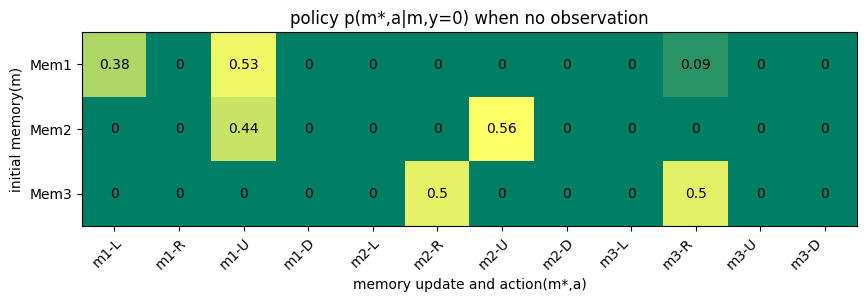

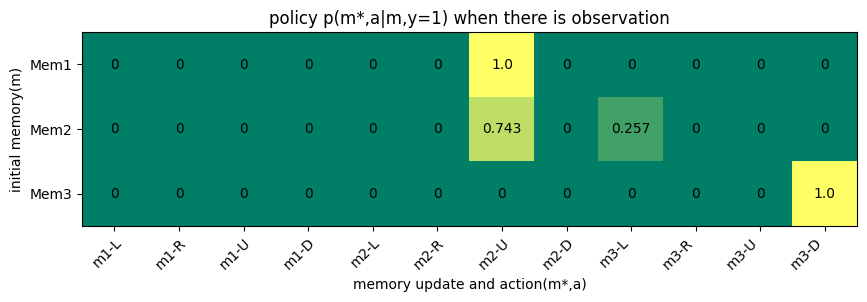

In [67]:
#POLICY ILLUSTRATION
# for y=0
p0=pi.reshape(O,M,M,A)[0].reshape(M,M*A)
actions = ["m1-L", "m1-R", "m1-U", "m1-D","m2-L", "m2-R", "m2-U", "m2-D","m3-L", 
           "m3-R", "m3-U", "m3-D","m4-L", "m4-R", "m4-U", "m4-D","m5-L", "m5-R", "m5-U", "m5-D"]
memory = ["Mem1", "Mem2", "Mem3",
           "Mem4", "Mem5"]

fig, ax = plt.subplots()
im = ax.imshow(p0,cmap='summer')
# Rotate the tick labels and set their alignment.

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(actions[:M*A])), labels=actions[:M*A])
ax.set_yticks(np.arange(len(memory[:M])), labels=memory[:M])

p00=np.round(p0,2)
for i in range(len(memory[:M])):
    for j in range(len(actions[:M*A])):
        if p00[i,j]==0.0:
            text = ax.text(j, i, 0,
                       ha="center", va="center", color="black") 
        else:
            text = ax.text(j, i, p00[i, j],
                       ha="center", va="center", color="black")
plt.title('policy p(m*,a|m,y=0) when no observation')
plt.ylabel('initial memory(m)',fontsize=10)
plt.xlabel('memory update and action(m*,a)',fontsize=10)
fig.set_size_inches(10, 6)
#plt.savefig(name_folder+'/policy_y0.png')


#for y=1
p1=pi.reshape(O,M,M,A)[1].reshape(M,M*A)
actions = ["m1-L", "m1-R", "m1-U", "m1-D","m2-L", "m2-R", "m2-U", "m2-D","m3-L", 
           "m3-R", "m3-U", "m3-D","m4-L", "m4-R", "m4-U", "m4-D","m5-L", "m5-R", "m5-U", "m5-D"]
memory = ["Mem1", "Mem2", "Mem3",
           "Mem4", "Mem5"]

fig, ax = plt.subplots()
im = ax.imshow(p1,cmap='summer')
# Rotate the tick labels and set their alignment.

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(actions[:M*A])), labels=actions[:M*A])
ax.set_yticks(np.arange(len(memory[:M])), labels=memory[:M])

p11=np.round(p1,3)
for i in range(len(memory[:M])):
    for j in range(len(actions[:M*A])):
        if p11[i,j]==0.0:
            text = ax.text(j, i, '0',
                       ha="center", va="center", color="black") 
        else:
            text = ax.text(j, i, p11[i, j],
                       ha="center", va="center", color="black")
        
plt.title('policy p(m*,a|m,y=1) when there is observation')
plt.ylabel('initial memory(m)',fontsize=10)
plt.xlabel('memory update and action(m*,a)',fontsize=10)
fig.set_size_inches(10, 6)
#plt.savefig(name_folder+'/policy_y1.png')

Found!


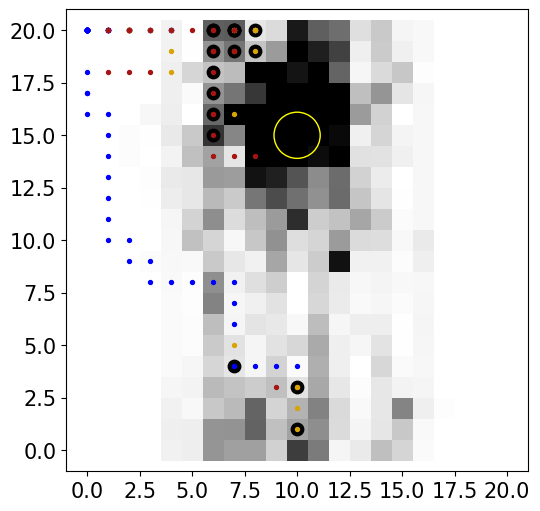

In [69]:
maxT=10000
rho0=init_sm2
trj, ret, _ = single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, maxT, PObs, init_sm2.reshape(-1), A)
scatter_x = trj[1:,1]
scatter_y = trj[1:,2]
group = trj[1:,3]
cdict = {1: '#D8A303', 4: '#0F984F', 2: '#A71414', 0:'blue',3:'lightgreen'}

fig, ax = plt.subplots()

ix = np.where(trj[1:,4] > 0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = 'black', s = 80)
ix = np.where(group == 0.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[0], label = 'Memory 0', s = 8)
ix = np.where(group == 1.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[1], label = 'Memory 1', s = 8)
ix = np.where(group == 2.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[2], label = 'Memory 2', s = 8)
ix = np.where(group == 3.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[3], label = 'Memory 3', s = 8)
ix = np.where(group == 4.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[4], label = 'Memory 3', s = 8)
#ax.legend()
#ax.legend()
ax.imshow((1-PObs[0,:]-5).reshape(M,Ly,Lx)[0,:],cmap='Greys')
fig.set_size_inches(10, 6)
crange=plt.Circle((Lx0,Ly0),find_range,fill=False,color='yellow')
ax.set_aspect(1)

ax.add_artist(crange)
#plt.title('{} threshold: {} memory states'.format(dth, M))

#plt.xlabel('x-position',fontsize=16)
#plt.ylabel('y-position',fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([-1,21,-1,21])
plt.show()


In [83]:
#evaluate
n_trajectories = 1000
maxt=500
av_ret = 0.
T = []
histo_tot = np.zeros((M, n_trajectories))
for i in range(n_trajectories):
    _,ret,tau = single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, gamma, PObs, initial_sm2.reshape(-1), A)
    av_ret += ret
    T.append(tau)


(array([130., 167., 106.,  92.,  71.,  63.,  63.,  36.,  42.,  34.,  31.,
         23.,  22.,  14.,  11.,  12.,   6.,   5.,   5.,   5.,   7.,   5.,
          5.,   6.,   4.,   7.,   3.,   2.,   3.,   4.,   1.,   4.,   2.,
          1.,   2.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   2.]),
 array([   0.  ,   24.04,   48.08,   72.12,   96.16,  120.2 ,  144.24,
         168.28,  192.32,  216.36,  240.4 ,  264.44,  288.48,  312.52,
         336.56,  360.6 ,  384.64,  408.68,  432.72,  456.76,  480.8 ,
         504.84,  528.88,  552.92,  576.96,  601.  ,  625.04,  649.08,
         673.12,  697.16,  721.2 ,  745.24,  769.28,  793.32,  817.36,
         841.4 ,  865.44,  889.48,  913.52,  937.56,  961.6 ,  985.64,
        1009.68, 1033.72, 1057.76, 1081.8 , 1105.84, 1129.88, 1153.92,
        1177.96, 1202.  ]),
 <BarContainer object of 50 artists>)

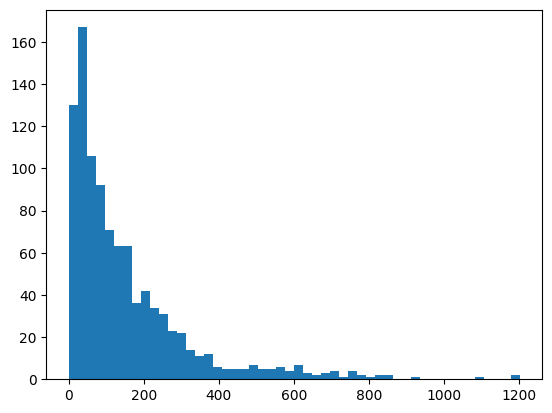

In [85]:
plt.hist(T, bins = 50,range=(0,np.max(T)))